In [1]:
%%capture
!pip install datasets

In [2]:
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim as opt
import torch.nn.functional as F
from fastprogress import progress_bar,master_bar

import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder

import logging
from fastcore.test import test_close

from library import *

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]


In [5]:
bs = 1024
tds = dsd.with_transform(transformi)


In [6]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##learner_V1

In [7]:
class Learner:
  def __init__(self , model,dls,loss_func , lr , opt_func = opt.SGD):
    fc.store_attr()
  
  def one_batch(self):
    self.xb , self.yb = to_device(self.batch , def_device)
    self.preds = self.model(self.xb)
    self.loss = self.loss_func(self.preds,self.yb)
    if self.model.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()
    with torch.no_grad():
      self.calc_stats()

  def calc_stats(self):
    acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
    self.accs.append(acc)
    n = len(self.xb)
    self.losses.append(self.loss * n)
    self.ns.append(n)

  def one_epoch(self,train):
    self.model.training=train
    dl = self.dls.train if train else self.dls.valid
    for self.num ,self.batch in enumerate(dl):
      self.one_batch()
    n = sum(self.ns)
    print(self.epoch , self.model.training , sum(self.losses).item()/n , sum(self.accs).item()/n)

  def fit(self , n_epochs):
    self.accs , self.losses   ,self.ns=[] ,[],[]
    self.model.to(def_device)
    self.opt = self.opt_func(self.model.parameters() , self.lr)
    self.n_epochs = n_epochs
    for self.epoch in range(n_epochs):
      self.one_epoch(True)
      with torch.no_grad():
        self.one_epoch(False)

In [8]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))


In [9]:
a,b = next(iter(dls.train))


In [10]:
aa = torch.tensor([1.,2.])
aa.requires_grad

False

In [11]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1846040364583332 0.6204333333333333
0 False 1.13284453125 0.6307571428571429


###basic callbacks

In [12]:
class CancelFitException(Exception):pass
class CancelBatchException(Exception):pass
class CancelEpochException(Exception):pass

In [13]:
class Callback():
  order =0

In [14]:
def run_cbs(cbs,method_name , learn=None):
  for cb in sorted(cbs , key = attrgetter('order')):
    method = getattr(cb , method_name , None)
    if method is not None:
      method(learn)

In [15]:
class CompletionCB(Callback):
  def before_fit(self,learn):
    self.count =0
  def after_batch(self , learn):
    self.count +=1
  def after_fit(self,learn):
    print(f"completed : {self.count} batches")

In [16]:
cbs = [CompletionCB()]


In [17]:
class Learner:
  def __init__(self , model,dls,loss_func , lr ,cbs, opt_func = opt.SGD):
    fc.store_attr()
  
  def one_batch(self):
    self.xb , self.yb = to_device(self.batch , def_device)
    self.preds = self.model(self.xb)
    self.loss = self.loss_func(self.preds,self.yb)
    if self.model.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

  def one_epoch(self,train):
    self.model.training=train
    dl = self.dls.train if train else self.dls.valid

    try:
      self.callback("before_epoch")
      for self.num ,self.batch in enumerate(dl):
        try:
          self.callback("before_batch")
          self.one_batch()
          self.callback("after_batch")
        except CancelBatchException as e:print(f"CancelBatchException hit by {e}")
    except CancelEpochException as e :print(f"CancelEpochException hit by {e}")


  def fit(self , n_epochs):
    self.accs , self.losses   ,self.ns=[] ,[],[]
    self.model.to(def_device)
    self.opt = self.opt_func(self.model.parameters() , self.lr)
    self.n_epochs = n_epochs
    try:
      self.callback("before_fit")
      for self.epoch in range(n_epochs):
        self.one_epoch(True)
        with torch.no_grad():
          self.one_epoch(False)
      self.callback("after_fit")
    except CancelFitException as e:print(f"CancelFitException hit  -- {e}")
  
  def callback(self , method_nm):
    run_cbs(self.cbs , method_nm , self)

In [18]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [19]:

model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

completed : 64 batches


In [20]:
class SingleBatchCB(Callback):
  order =1
  def after_batch(self,learn):
    raise CancelFitException("SingleBatchCB")

In [21]:

learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

CancelFitException hit  -- SingleBatchCB


In [22]:
class Metric:
  def __init__(self):
    self.reset()
  def reset(self):
      self.vals ,self.ns =[],[]
  def add(self ,inp , targ=None,n=1):
    self.last = self.calc(inp,targ)
    self.vals.append(self.last)
    self.ns.append(n)
  @property
  def value(self):
    ns = tensor(self,ns)
    return (tensor(self.vals)*ns).sum() / ns.sum()
  def calc(self ,inps,targs):
    return inps  

In [23]:
class Accuracy(Metric):
  def calc(self,inps,targs):
    return (inps == targs).float().mean()

In [24]:
%%capture 
!pip install torcheval

In [25]:
from torcheval.metrics import MulticlassAccuracy,Mean


In [26]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [27]:
class MetricsCB(Callback):
  def __init__(self, *ms ,**metrics):
    for o in ms:
      metrics[type(o).__name__] = o
    self.metrics = metrics
    self.all_metrics = copy(metrics)
    self.all_metrics['loss'] = self.loss = Mean()

  def _log(self,d):
    print(d)
  
  def before_fit(self,learn):
    learn.metrics= self
  def before_epoch(self,learn):
    [o.reset() for o in self.all_metrics.values()]
  
  def after_epoch(self,learn):
    log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
    log['epoch'] = learn.epoch
    log['train'] = 'train' if learn.model.training else "eval"
    self._log(log)
  def after_batch(self,learn):
    x,y,*_ = to_cpu(learn.batch)
    for m in self.metrics.values():
      m.update(to_cpu(learn.preds) ,y)
      self.loss.update(to_cpu(learn.loss) , weight = len(x))


In [28]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [29]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

In [30]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [31]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
     

globals() returns a dictionary that represents the current global symbol table, which contains all the global variables, functions, and classes defined in the module. It allows you to access and manipulate these global entities programmatically.

In [32]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

@property is a decorator that allows you to define a method that can be accessed like an attribute

If an attribute is not found in an object's instance dictionary, Python will look for the attribute in the object's class and its parent classes. If the attribute is still not found, Python will call the __getattr__ method of the object (if it's defined) and pass the name of the attribute as a string. The __getattr__ method can then return a value for the attribute, raise an AttributeError exception, or do something else entirely.

In [33]:
from torch import optim
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training
     

accuracy,loss,epoch,train
0.616,1.168,0,train
0.722,0.777,0,eval


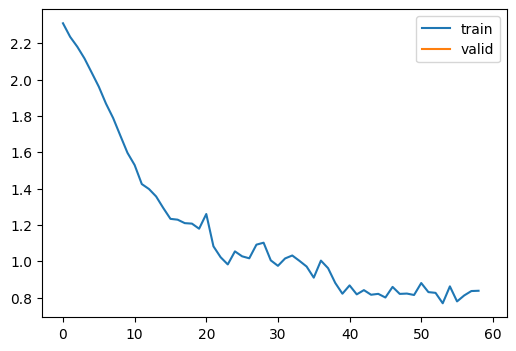

In [34]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [35]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()


In [36]:
class MomentumLearner(TrainLearner):
  def __init__(self , model,dls ,loss_func , lr=None , cbs = None , opt_func = optim.SGD , mom = .85):
    super().__init__(model , dls,loss_func , lr , cbs , opt_func)
    self.mom =mom
  def zero_grad(self):
    with torch.no_grad():
      for p in self.model.parameters():
        p.grad *= self.mom

accuracy,loss,epoch,train
0.671,0.965,0,train
0.788,0.587,0,eval


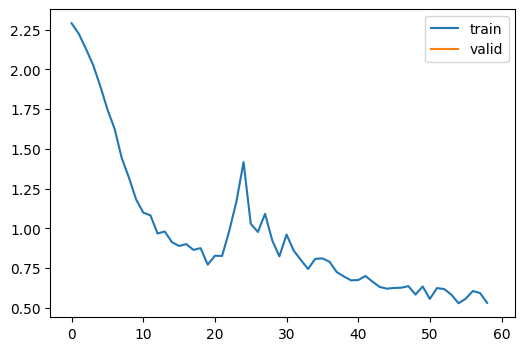

In [37]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

In [38]:
from torch.optim.lr_scheduler import ExponentialLR


In [39]:
class LRFinderCallback(Callback):
  def __init__(self , gamma = 1.3 , max_mult =3):
    fc.store_attr()
  
  def before_fit(self,learn):
    self.sched = ExponentialLR(learn.opt , self.gamma)
    self.lrs , self.losses = [],[]
    self.min = math.inf

  def after_batch(self,learn):
    if not learn.training : raise CancelEpochException("LRFinderCallback")
    self.lrs.append(learn.opt.param_groups[0]['lr'])
    loss = to_cpu(learn.loss)
    self.losses.append(loss)
    if loss < self.min:
      self.min = loss
    if math.isnan(loss) or (loss > self.min * self.max_mult):
      raise CancelFitException("LRFinderCallback")
    self.sched.step()
  def cleanup_fit(self,learn):
    plt.plot(self.lrs , self.losses)
    plt.xscale("log")

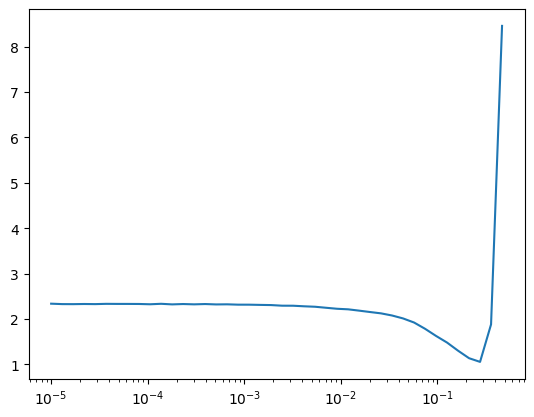

In [40]:

cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCallback())

##activation

In [41]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [42]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
     

  0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [44]:

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
     

In [45]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn
     

accuracy,loss,epoch,train
0.159,2.301,0,train
0.316,2.142,0,eval


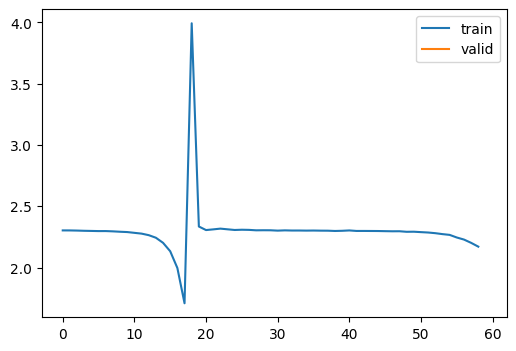

In [46]:
import random
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In [47]:
class SequentialModel(nn.Module):
  def __init__(self , *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_std = [[] for _ in layers]

  def __call__(self , x):
    for i , l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(to_cpu(x.mean()))
      self.act_std[i].append(to_cpu(x.std()))
    return x
  def __iter__(self):
    return iter(self.layers)        

accuracy,loss,epoch,train
0.203,2.250,0,train
0.263,1.976,0,eval


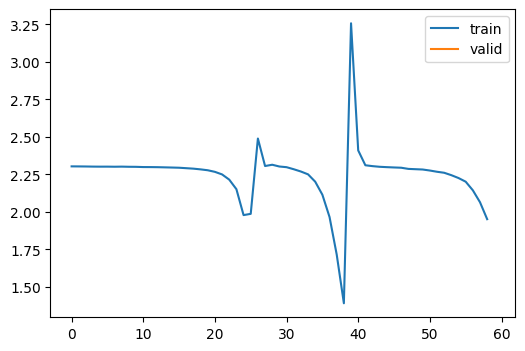

In [48]:
model = SequentialModel(*cnn_layers())
learn = fit(model)

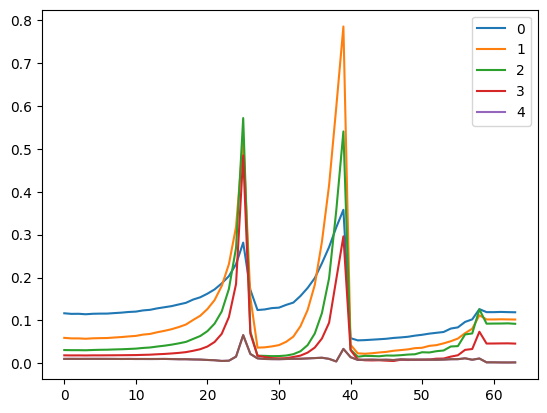

In [49]:

for l in model.act_means: plt.plot(l)
plt.legend(range(5));

###Pytorch hooks
Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.



A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [50]:

set_seed(1)
model = nn.Sequential(*cnn_layers())

act_means = [[] for _ in model]
act_stds  = [[] for _ in model]
 

In [51]:
def append_stats(i , mod , inp,outp):
  act_means[i].append(to_cpu(outp).mean())
  act_stds [i].append(to_cpu(outp).std())

In [52]:
for i, m in enumerate(model):
  m.register_forward_hook(partial(append_stats , i))

accuracy,loss,epoch,train
0.159,2.301,0,train
0.316,2.142,0,eval


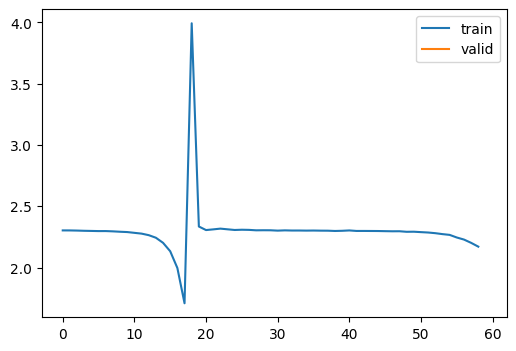

In [53]:
fit(model)

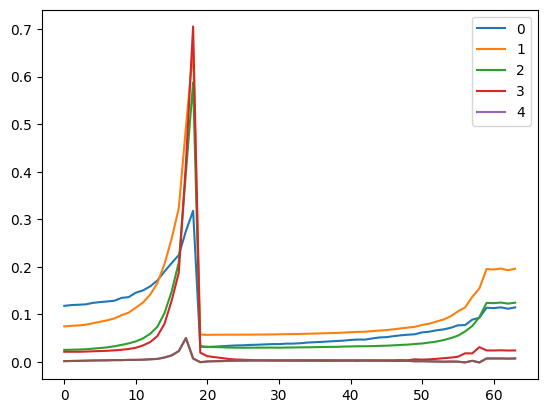

In [54]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

###Hook class
We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [55]:
class Hook():
  def __init__(self , m , f):
    self.hook = m.register_forward_hook(partial(f , self))
  def remove(self):
    self.hook.remove()
  def __del__(self):
    self.remove()

In [56]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [57]:

set_seed(1)
model = nn.Sequential(*cnn_layers())


In [58]:
hooks = [Hook(l , append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.159,2.301,0,train
0.316,2.142,0,eval


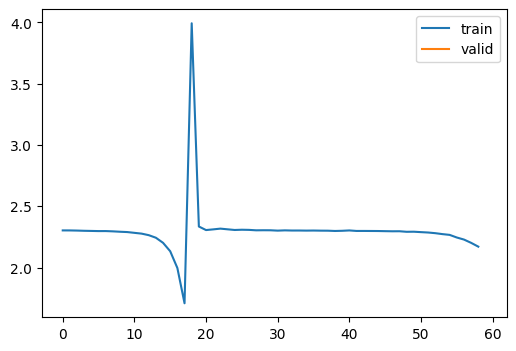

In [59]:
learn = fit(model)


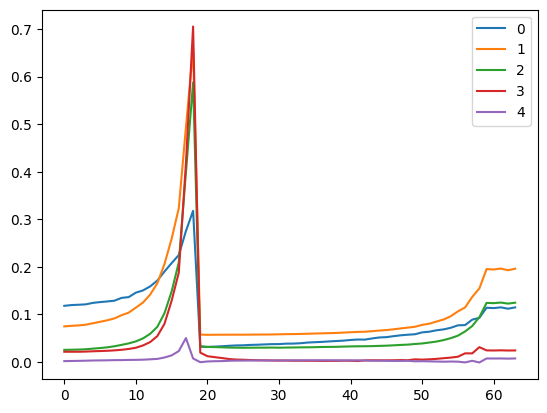

In [60]:
for h in hooks:
  plt.plot(h.stats[0])
  h.remove()
plt.legend(range(5))

we make this class as context manager

In [61]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()
     

accuracy,loss,epoch,train
0.148,2.264,0,train
0.100,2.303,0,eval


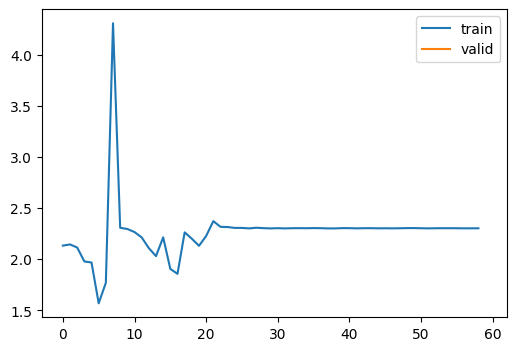

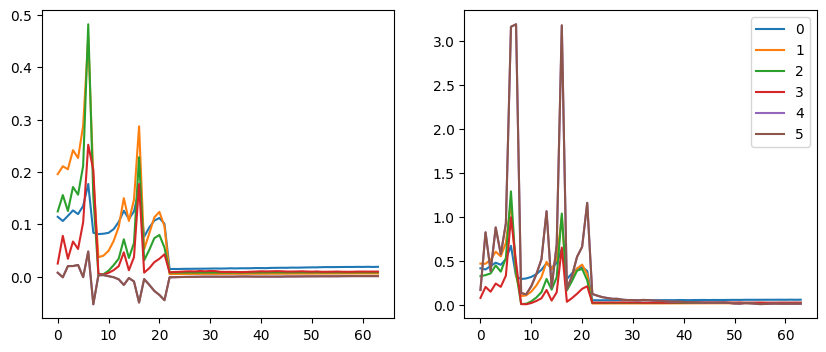

In [62]:

with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

In [63]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: 
          mods=self.mods
        else: 
          mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [64]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))


accuracy,loss,epoch,train
0.159,2.301,0,train
0.316,2.142,0,eval


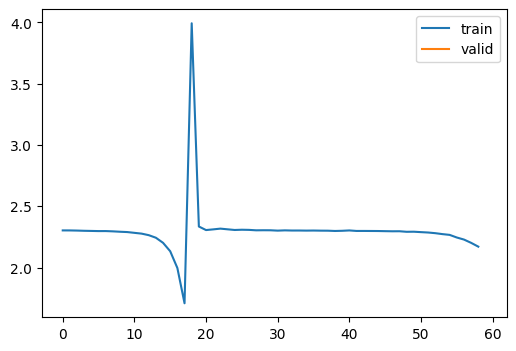

In [65]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

In [66]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.159,2.301,0,train
0.316,2.142,0,eval


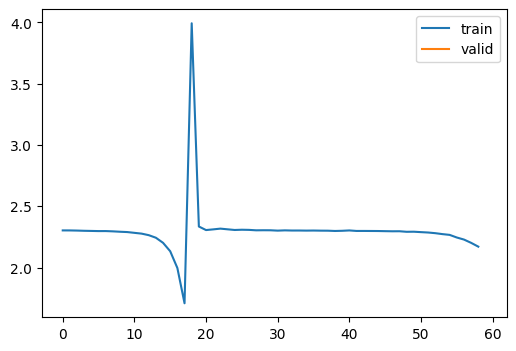

In [67]:

set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);


In [68]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()


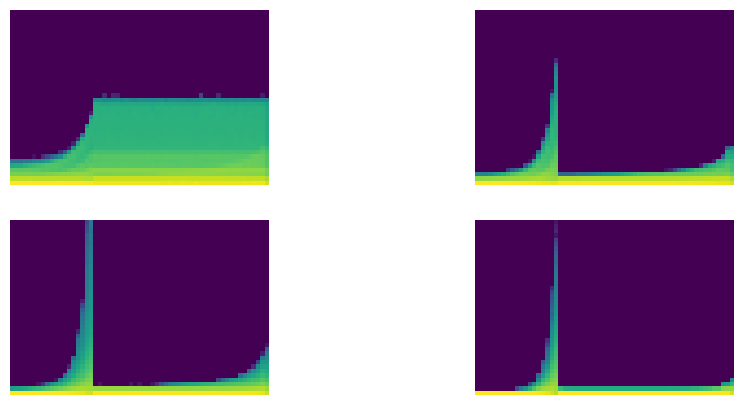

In [69]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [70]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [71]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))


accuracy,loss,epoch,train
0.159,2.301,0,train
0.316,2.142,0,eval


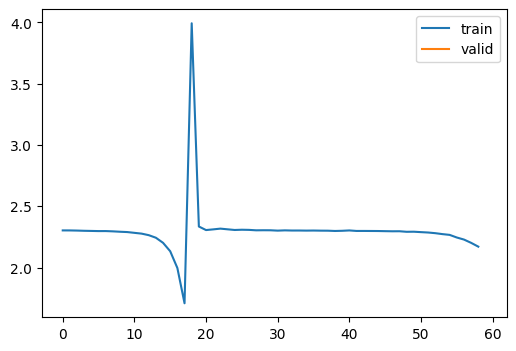

In [72]:

set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

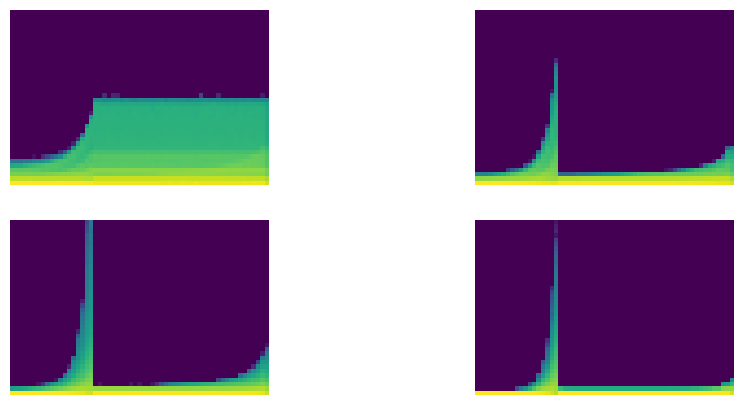

In [73]:
astats.color_dim()


###code to clean memory

In [74]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''  

In [75]:
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [76]:
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

####Glorot/Xavier init

In [77]:
x = torch.randn(200,100)
for i in range(50):
  x = x @ torch.randn(100,100)
x[:5 , :5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is nans everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:



In [78]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in "Understanding the Difficulty of Training Deep Feedforward Neural Networks". The right scale for a given layer is  $1/\sqrt(n_i) , where n_i $represents the number of inputs.

In [79]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[-0.0344, -0.4355,  0.6430,  0.2085,  0.3024],
        [-0.8526, -0.4839,  0.1696, -0.3175, -0.0822],
        [-0.8308,  0.8031,  1.1210,  0.4236,  0.5240],
        [-0.1868, -0.1097, -0.3353, -0.3296, -0.3509],
        [ 0.1804,  0.6249,  0.2772,  0.1417,  0.2608]])

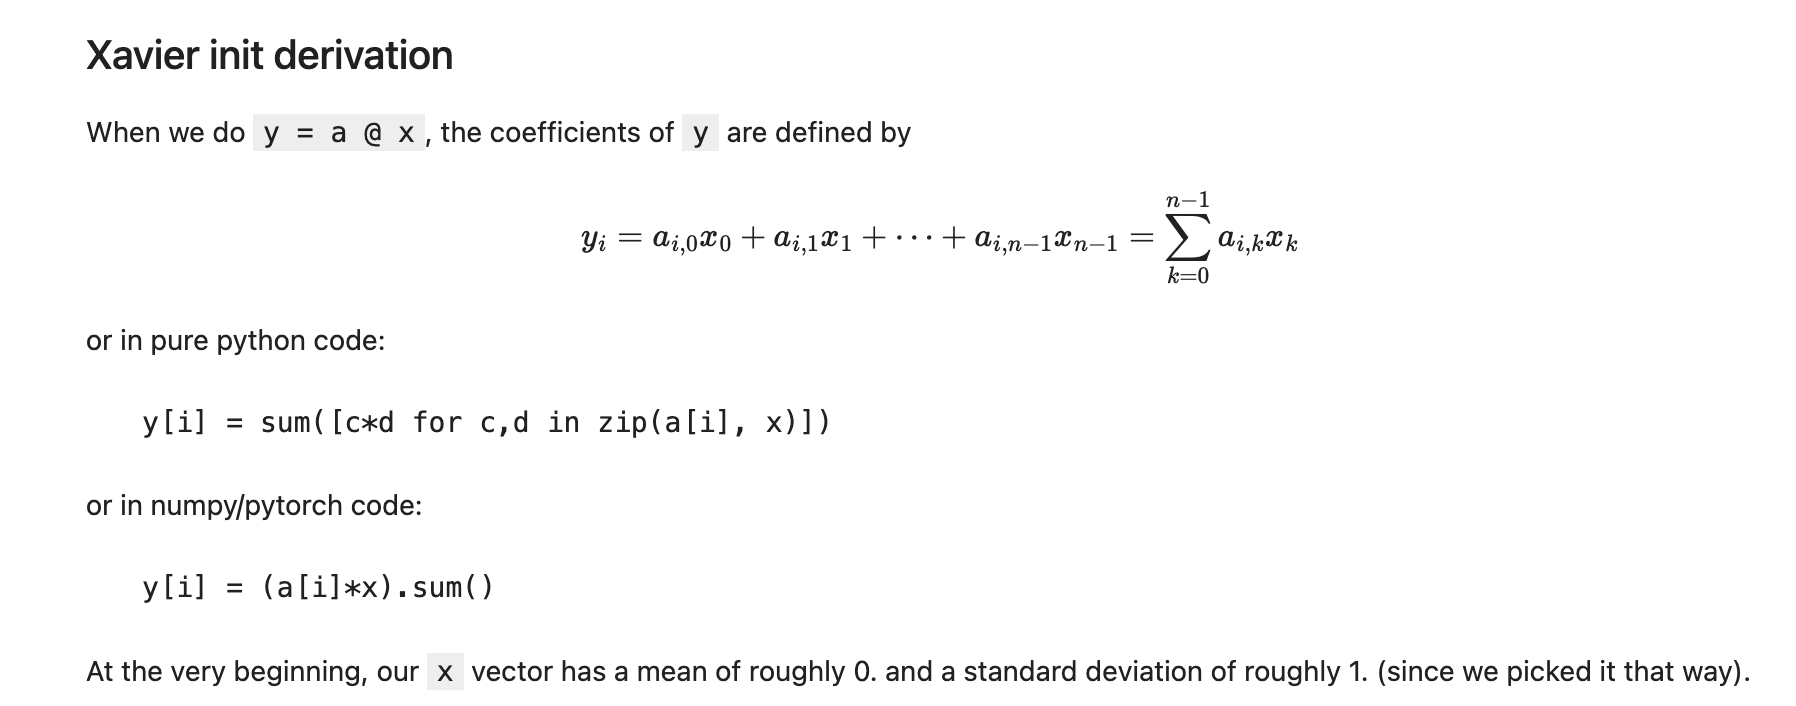

In [80]:
x = torch.randn(100)
x.mean() , x.std()

(tensor(0.0016), tensor(0.9602))

### Kaiming/He init

In [81]:
x = torch.randn(200,100)
y = torch.randn(200)

from math import sqrt

w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.randn(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.randn(1)

In [82]:
def lin(x,w,b):
  return x @ w +b

In [83]:
l1 = lin(x,w1,b1)
l1.mean() , l1.std()


(tensor(0.1643), tensor(1.3369))

In [84]:
def relu(x):
  return x.clamp_min(0.)

In [85]:
l2 = relu(l1)
l2.mean() , l2.std()

(tensor(0.6256), tensor(0.8299))

this xavier init doesn't work with relu activation

Kaiming He et al. show that we should use the following scale instead: $\sqrt(2/n_i)$  where $n_i $  is the number of inputs of our model.

In [86]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.7686, 0.0000, 0.7377, 0.2180, 0.0000],
        [0.8034, 0.0000, 0.6844, 0.1372, 0.0000],
        [0.9597, 0.0000, 0.7206, 0.2444, 0.0000],
        [1.3273, 0.0000, 1.3511, 0.0000, 0.1301],
        [0.6777, 0.0000, 0.8161, 0.4742, 0.0000]])

In [87]:
from torch.nn import init
def init_weights(m):
  if isinstance(m , (nn.Conv1d ,nn.Conv2d ,nn.Conv3d)):
    init.kaiming_normal_(m.weight)

In [88]:
model.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

###input normalization

In [89]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd 


(tensor(0.2834), tensor(0.3527))

In [90]:
class BatchTransformCB(Callback):
  def __init__(self,tfm,on_train=True , on_valid =True):
    fc.store_attr()
  
  def before_batch(self,learn):
    if (self.on_train and learn.training) or (self.on_val and not learn.training):
      learn.batch = self.tfm(learn.batch)

In [91]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

In [92]:
m = 784

In [93]:
xl = 'image'
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [95]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [96]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

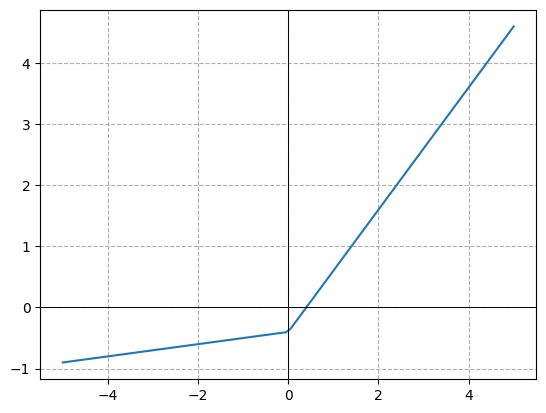

In [97]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))


In [98]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [99]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [100]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [101]:

act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [102]:
model = get_model(act_gr).apply(iw)


accuracy,loss,epoch,train
0.733,0.785,0,train
0.838,0.452,0,eval
0.863,0.376,1,train
0.859,0.377,1,eval
0.880,0.325,2,train
0.866,0.353,2,eval


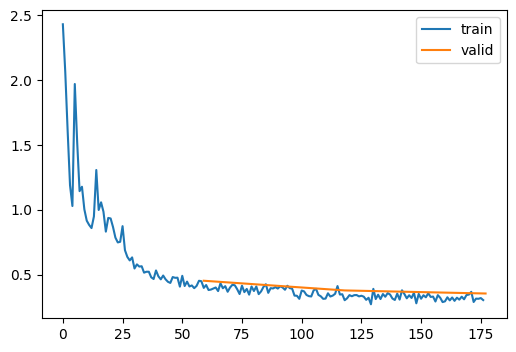

In [103]:

set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [104]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()
     

In [105]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]


In [106]:
for ms in zip(relus,convs): lsuv_init(model, *ms, xb.to(def_device))


accuracy,loss,epoch,train
0.770,0.652,0,train
0.832,0.459,0,eval
0.862,0.377,1,train
0.855,0.397,1,eval
0.877,0.336,2,train
0.862,0.374,2,eval


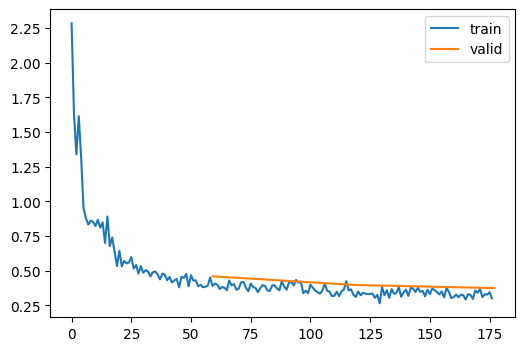

In [107]:

set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

## LayerNorm and BatchNorm

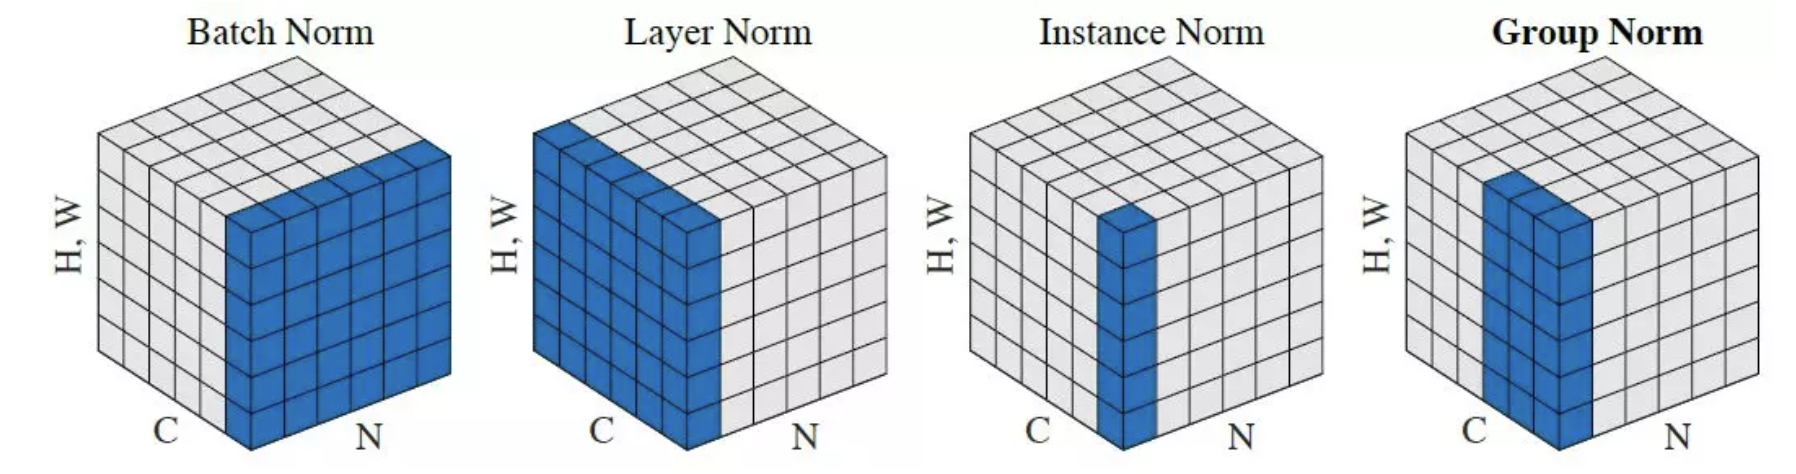

In [108]:
class LayerNorm(nn.Module):
  def __init__(self , dummy , eps = 1e-5):
    super().__init__()
    self.eps = eps
    self.mult  = nn.Parameter(tensor(1.))
    self.add  = nn.Parameter(tensor(1.))

  def forward(self , x):
    m = x.mean((1,2,3) , keepdim=True)
    v = x.var((1,2,3) , keepdim=True)
    x = (x -m ) / ((v + self.eps).sqrt())
    return x * self.mult + self.add



In [109]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [110]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.105,63315.577,0,train
0.100,953162.317,0,eval
0.098,26965111308.655,1,train
0.100,406238998508.339,1,eval
0.099,11678735800325408.000,2,train
0.098,300893231666482368.000,2,eval


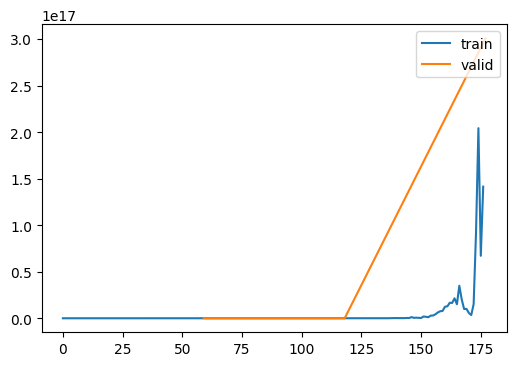

In [111]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

ergey Ioffe and Christian Szegedy released "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" in 2015, saying:

Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

In [112]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.793,0.572,0,train
0.850,0.434,0,eval
0.872,0.347,1,train
0.865,0.358,1,eval
0.885,0.310,2,train
0.875,0.341,2,eval


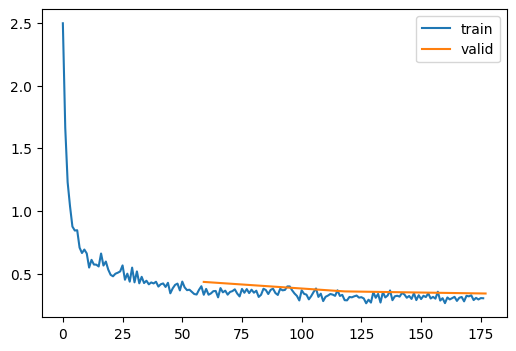

In [113]:

model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

#OPtimizer

In [114]:

xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [115]:

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB()]

In [116]:
class SGD:
  def __init__(self, params , lr , wd = 0):
    params = list(params)
    fc.store_attr()
    self.i = 0

  def step(self):
    with torch.no_grad():
      for p in self.params:
        self.reg_step(p)
        self.opt_step(p)
    self.i += 1

  def opt_step(self,p):
    p -= p.grad * self.lr 
  
  def reg_step(self, p):     # regularization
    if self.wd != 0:
      p *= self.lr*self.wd
  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()


In [117]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)


accuracy,loss,epoch,train
0.769,0.647,0,train
0.825,0.495,0,eval


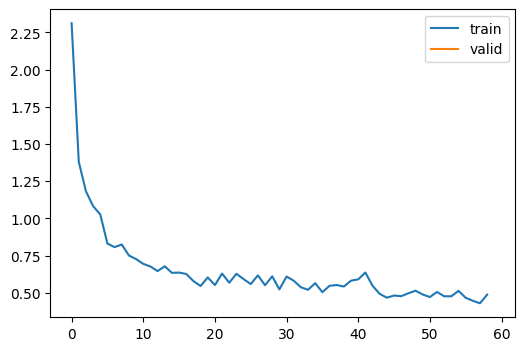

In [118]:
learn.fit(1)

In [119]:
class Momentum(SGD):
  def __init__(self, params , lr , wd=0. , mom = .9):
    super().__init__(params , lr=lr,wd=wd)
    self.mom = mom
  
  def opt_step(self , p):
    if not hasattr(p , 'grad_avg'):
      p.grad_avg = torch.zeros_like(p.grad)
      p.grad_avg = p.grad_avg * self.mom + p.grad* (1- self.mom)
      p -= self.lr * p.grad_avg

In [120]:

set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.404,1.801,0,train
0.415,1.794,0,eval


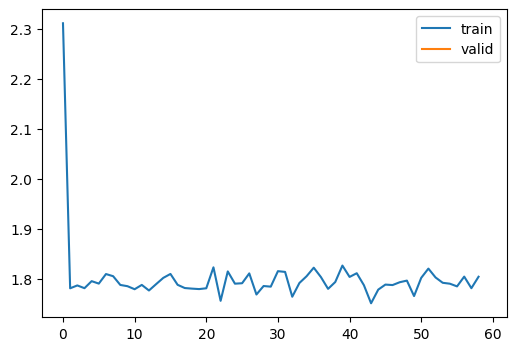

In [121]:
learn.fit(1)

In [122]:

class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

In [123]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.796,0.574,0,train
0.843,0.433,0,eval


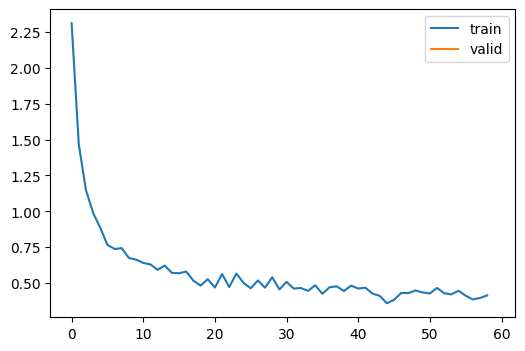

In [124]:

set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(1)


##Schedulers

In [125]:
from torch.optim import lr_scheduler

In [126]:
class BaseSchedCB(Callback):
  def __init__(self, sched):
    self.sched = sched
  def before_fit(self , learn):
    self.sched = self.sched(learn.opt)
  def _step(self , leanrn):
    if learn.training:
      self.sched.step()

In [127]:
class BatchSchedCB(BaseSchedCB):
  def after_batch(self , learn):
    self._step(learn)

class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

In [128]:
class HasLearnCB(Callback):
  def before_fit(self,learn):
    self.learn = learn
  def after_fit(self,learn):
    self.learn = None
  

In [129]:
class RecorderCB(Callback):
  def __init__(self ,**d):
    self.d =d
  def before_fit(self,learn):
    self.recs = {k:[] for k in self.d}
    self.pg = learn.opt.param_groups[0]

  def after_batch(self,learn):
    if not learn.training:
      return
    for k,v in self.d.items():
      self.recs[k].append(v(self))
  def plot(self):
    for k , v in self.recs.items():
      plt.plot(v , label =k)
      plt.legend()
      plt.show()

In [130]:
def _lr(cb): return cb.pg['lr']


In [131]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.796,0.553,0,train
0.854,0.400,0,eval
0.875,0.344,1,train
0.866,0.361,1,eval
0.890,0.301,2,train
0.875,0.341,2,eval


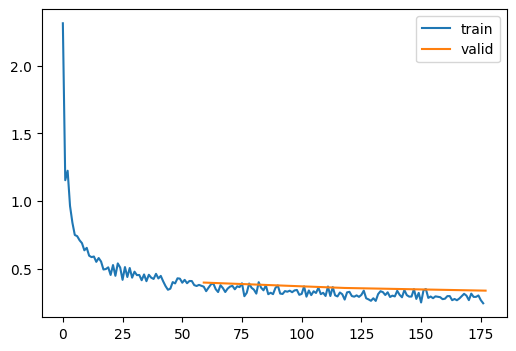

In [132]:
set_seed(42)
model = get_model(act_gr , norm = nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr = _lr)
xtra = [BatchSchedCB(sched),rec]

learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

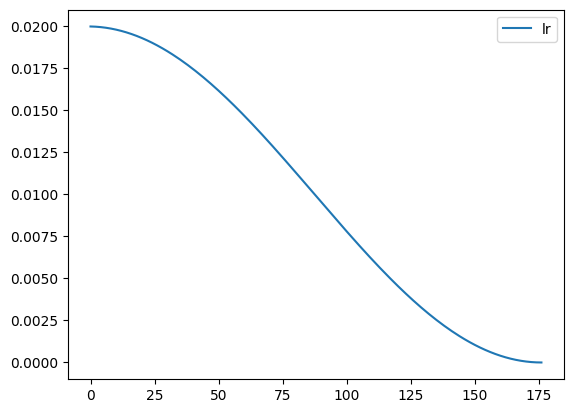

In [133]:
rec.plot()

In [134]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)
